In [1]:
import os
import inspect
import sys

In [2]:
import sys
sys.path.append("../")
sys.path.append('../../../')

In [3]:
from gnn_boundary.datasets import *
from gnn_boundary.models import *
from gnn_boundary.utils import *
from gnn_boundary.criteria import *
from gnn_boundary.regularizations import *
from gnn_boundary import Trainer, Evaluator, GraphSampler

import shelve
import torch
import numpy as np

from DatasetWrapper import *

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from graph_generation import NodeCountGraphs as GG

In [5]:
dataset = GG.NodeCountGraphs(2000).getDataset()
num_cls = 2

In [6]:
dataset = DatasetWrapper(dataset, num_cls=2, node_feat= 1,name="node_count", color_dict = {0:"black"})

In [7]:
import explainers.GNNBoundary.gnn_boundary.models as models

In [8]:
model = models.LinearGCNClassifier(hidden_channels = 16, node_features = 1, num_classes=2)

In [9]:
import os
cwd = os.getcwd()
file_path = os.path.abspath(os.path.join(cwd, '../../../model/report_models/counting.pt'))

In [10]:
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [11]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 1.0,
 'cm': array([[1091,    0],
        [   0,  909]], dtype=int64),
 'f1': {0: 1.0, 1: 1.0}}

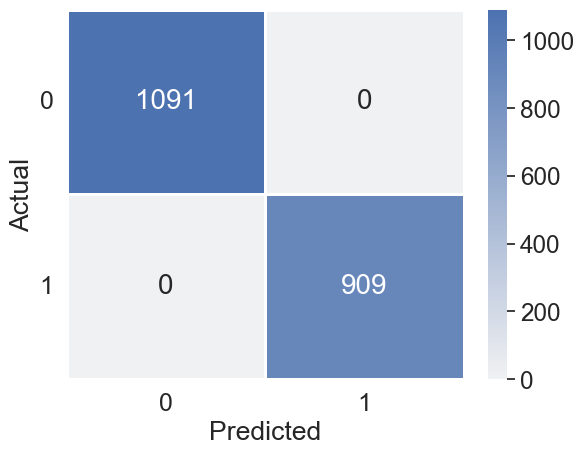

In [13]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [14]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


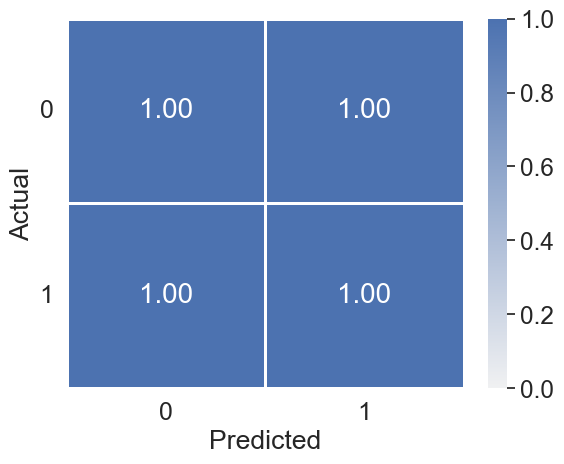

In [15]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [16]:
trainer = {}
sampler = {}

In [17]:
from gnn_boundary import Trainer

In [37]:
cls_1, cls_2 = 0, 1
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        temperature=0.5,
        num_node_cls=1,#len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=2
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=0.005)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [39]:
trainer[0, 1].train(
    iterations=200,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=12,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

 39%|███▉      | 129/329 [00:00<?, ?it/s]


True

n=12 m=7
logits=[-3.234257936477661, 3.9489705562591553]
probs=[0.0007586368010379374, 0.9992413520812988]


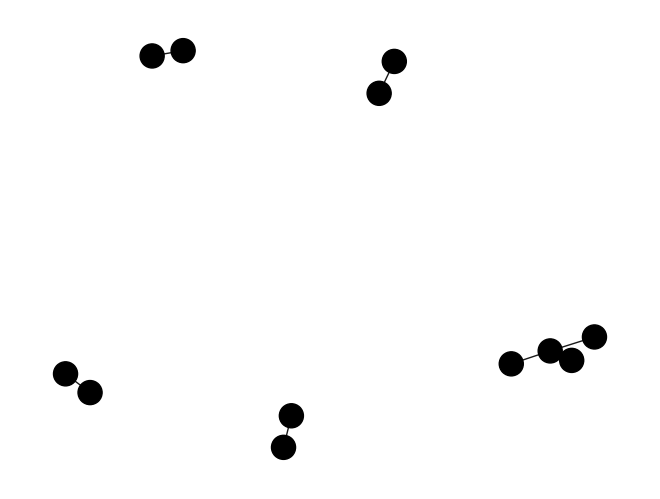

In [40]:
test = trainer[0, 1].evaluate(threshold=0.5, show=True)

In [34]:
from utility_functions import *

In [41]:
graph = dataset.convertNxToData(test)

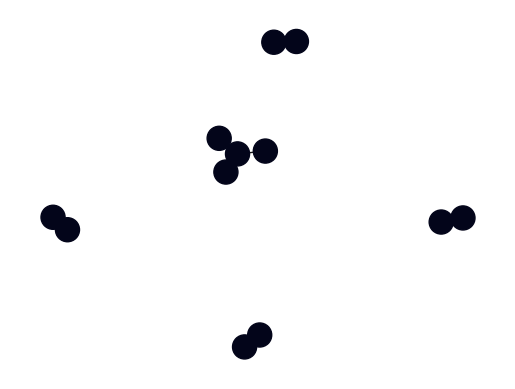

In [42]:
printGraph(graph,"./images/nodeCountingBoundary")